This dataset from neptune.ai: https://app.neptune.ai/o/showcase/org/StockPrediction/metadata?path=&attribute=data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/content/stock_market_data-AAPL.csv")
df.head()

,Date,Low,High,Close,Open
0,1999-11-01,77.37,80.69,77.62,80.00
1,1999-11-02,77.31,81.69,80.25,78.00
2,1999-11-03,81.00,83.25,81.50,81.62
3,1999-11-04,80.62,85.37,83.62,82.06
4,1999-11-05,84.00,88.37,88.31,84.62


In [3]:
df.shape

(5454, 5)

In [4]:
df.describe()

,Low,High,Close,Open
count,5454.000000,5454.000000,5454.000000,5454.000000
mean,172.681087,176.702928,174.747033,174.761299
std,156.094862,158.912581,157.542041,157.608887
min,12.720000,13.190000,13.120000,12.990000
25%,62.885000,65.000000,63.885000,64.207500
50%,122.240000,126.030000,124.390000,124.145000
75%,213.227500,219.420000,215.887500,216.290000
max,699.570000,705.070000,702.100000,702.410000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5454 non-null   object 
 1   Low     5454 non-null   float64
 2   High    5454 non-null   float64
 3   Close   5454 non-null   float64
 4   Open    5454 non-null   float64
dtypes: float64(4), object(1)
memory usage: 213.2+ KB


In [6]:
test_ratio = 0.2
train_ratio = 1 - test_ratio

# Calculate the split point
split_point = int(len(df) * train_ratio)

# Split the data
train = df.iloc[:split_point][["Close"]]
test = df.iloc[split_point:][["Close"]]

print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")

Train size: 4363
Test size: 1091


In [ ]:
!pip install mplcursors

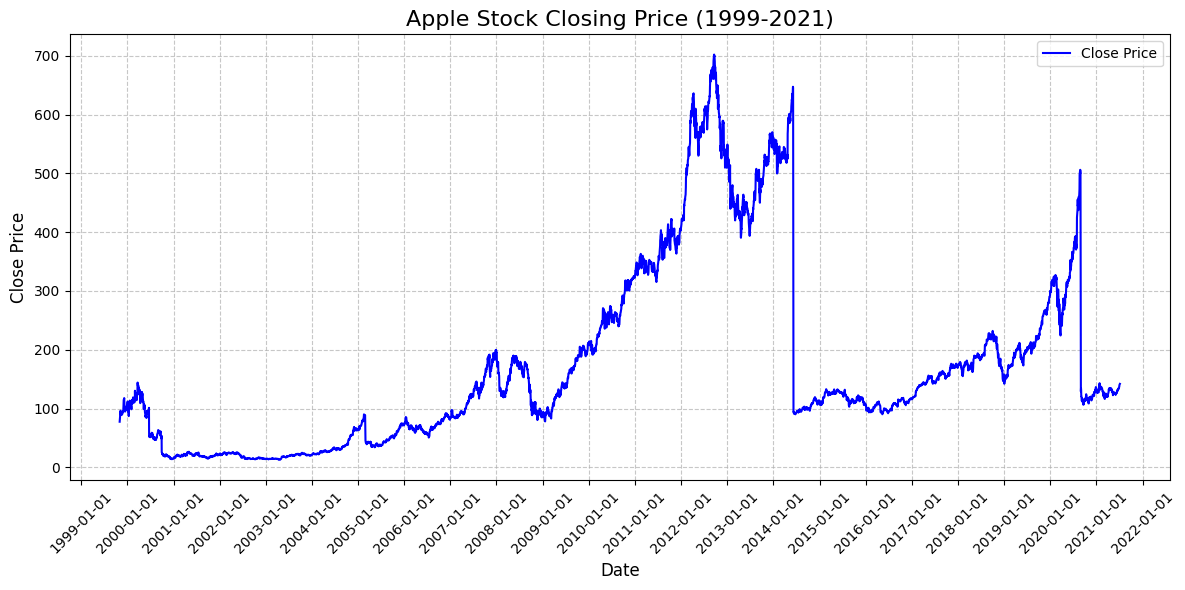

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplcursors import cursor

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot(df.index, df['Close'], color='blue', label='Close Price')

ax.set_title("Apple Stock Closing Price (1999-2021)", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Close Price", fontsize=12)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

cursor = cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(
    f'Date: {sel.target[0]:%Y-%m-%d}\nClose: ${sel.target[1]:.2f}'))

plt.tight_layout()
plt.show()

In [10]:
def seqX_outY(data, N, offset):
  X = []
  y = []

  for i in range(offset, len(data)):
    X.append(data[i - N : i])
    y.append(data[i])

  return np.array(X), np.array(y)

RMSE(Root Mean Squared Error) and MAPE(Mean Absoulte Percentage Error %) metrics will be used for measures of forecast accuracy.

RMSE gives the differences between predicted and true values, whereas MAPE (%) measures this difference relative to the true values.

In [11]:
def calculate_rmse(y_true, y_pred):
  rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
  return rmse

def calculate_mape(y_true, y_pred):
  y_pred, y_true = np.array(y_pred), np.array(y_true)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  return mape



Next, is to defined a function for evaluation metrics for technical analysis.

In [12]:
def calculate_perf_metrics(df, split_point, var):
    ### RMSE
    rmse = calculate_rmse(
        np.array(df.iloc[split_point:]["Close"]),
        np.array(df.iloc[split_point:][var]),
    )
    ### MAPE
    mape = calculate_mape(
        np.array(df.iloc[split_point:]["Close"]),
        np.array(df.iloc[split_point:][var]),
    )
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    return rmse, mape

Defined a function for the plot to plot the trend of the stock prices

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplcursors import cursor

def plot_stock_trend(var, cur_title, stockprices=df):
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax2 = ax1.twinx()

    line1, = ax1.plot(stockprices.index, stockprices["Close"], color='blue', label="Close")
    line2, = ax2.plot(stockprices.index, stockprices[var], color='red', label=var)
    line3, = ax1.plot(stockprices.index, stockprices["200day"], color='green', label="200 day MA")

    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("Stock Price ($)", fontsize=12)
    ax2.set_ylabel(var, fontsize=12)

    # Format x-axis to show only the year
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Adjust the spacing of year labels (you can experiment with different intervals)
    ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))  # Show a tick every 2 years

    plt.xticks(rotation=45)

    ax1.grid(True, linestyle='--', alpha=0.7)

    lines = [line1, line2, line3]
    ax1.legend(lines, [l.get_label() for l in lines], loc='upper left')

    plt.title(cur_title, fontsize=16)

    cursor_obj = cursor(hover=True)
    cursor_obj.connect("add", lambda sel: sel.annotation.set_text(
        f'Date: {sel.target[0]:%Y-%m-%d}\nValue: {sel.target[1]:.2f}'))

    plt.tight_layout()
    plt.show()

# **Simple Moving Average**

First, use Simple Moving Average to calculates the average of a range of stock closing prices over a specific number of periods in the range. By building an Simple Moving Average model, will compute the 50 days, as well as add 200 days for good measurement.

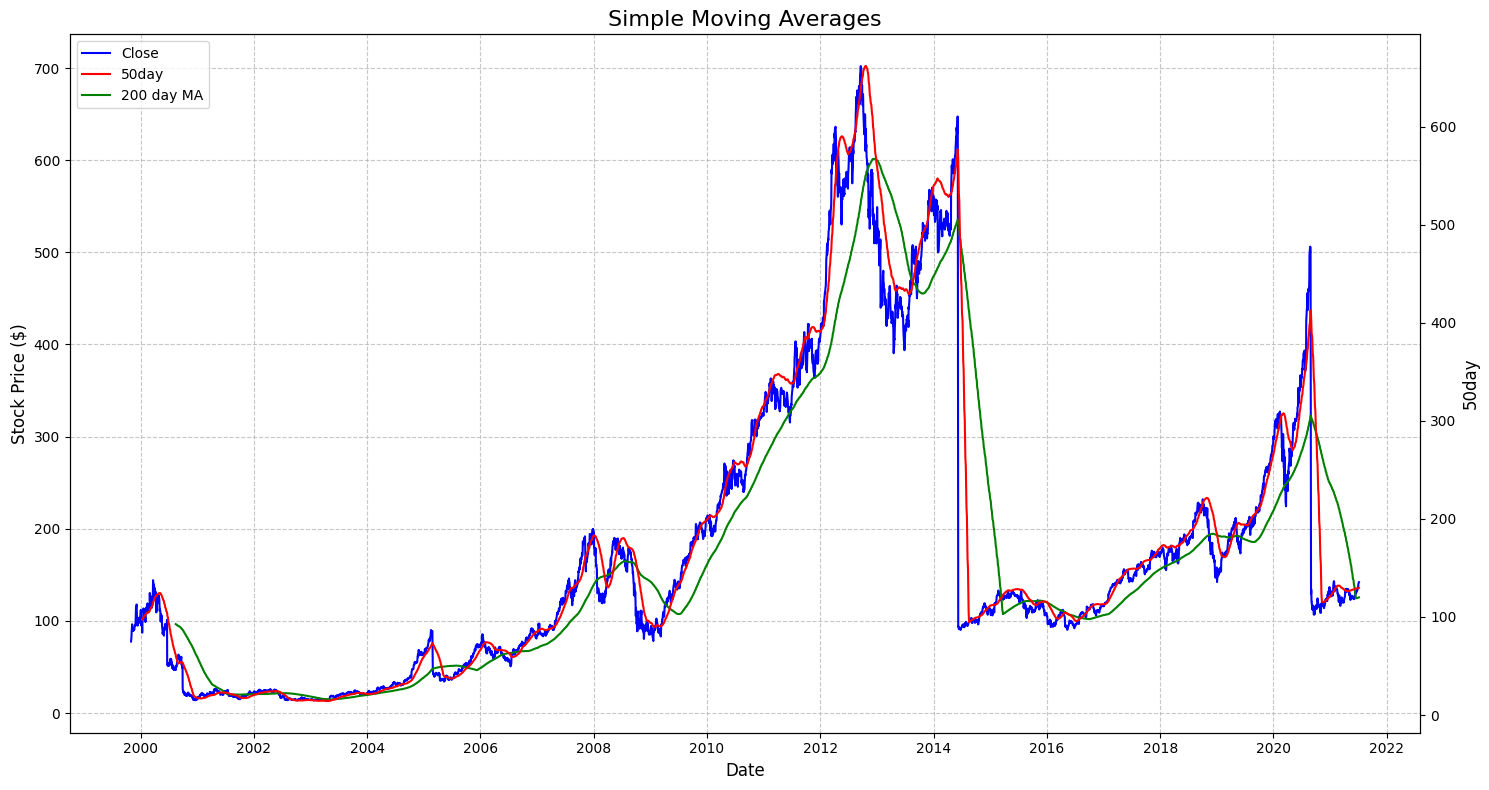

RMSE: 43.76848947969163
MAPE: 12.529053089133422


In [19]:
window_size = 50

window_var = f"{window_size}day"

df[window_var] = df["Close"].rolling(window_size).mean()

### Include a 200-day SMA for reference
df["200day"] = df["Close"].rolling(200).mean()

### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title="Simple Moving Averages")
rmse_sma, mape_sma = calculate_perf_metrics(df=df, split_point=split_point, var=window_var)


The results of Simple Moving Average for RMSE is 43.8, while MAPE results is 12.53%.

# **Exponential Moving Average**

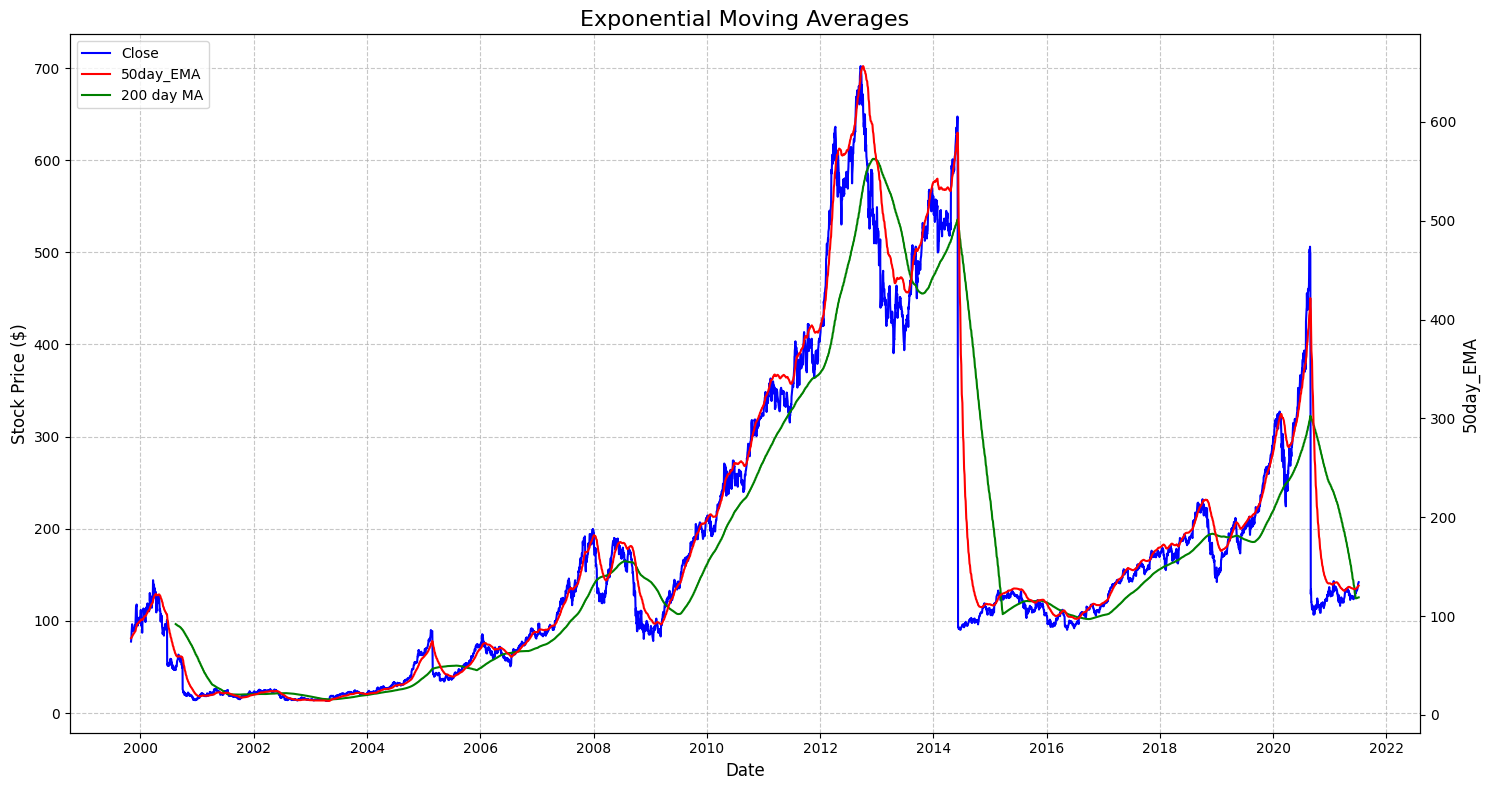

RMSE: 36.67593508712043
MAPE: 10.71389916884245


In [20]:
window_ema_var = f"{window_var}_EMA"

# Calculate the 50-day exponentially weighted moving average
df[window_ema_var] = (
    df["Close"].ewm(span=window_size, adjust=False).mean()
)
df["200day"] = df["Close"].rolling(200).mean()

### Plot and performance metrics for EMA model
plot_stock_trend(
    var=window_ema_var, cur_title="Exponential Moving Averages")
rmse_ema, mape_ema = calculate_perf_metrics(df=df, split_point=split_point, var=window_ema_var)

# **LSTM**

In [21]:
layer_units = 50
optimizer = "adam"
cur_epochs = 15
cur_batch_size = 20

cur_LSTM_args = {
    "units": layer_units,
    "optimizer": optimizer,
    "batch_size": cur_batch_size,
    "epochs": cur_epochs,
}


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[["Close"]])
scaled_data_train = scaled_data[: train.shape[0]]

X_train, y_train = seqX_outY(scaled_data_train, window_size, window_size)


Epoch 1/15, Loss: 0.3291
Epoch 2/15, Loss: 0.1980
Epoch 3/15, Loss: 0.0415
Epoch 4/15, Loss: 0.0307
Epoch 5/15, Loss: 0.0157
Epoch 6/15, Loss: 0.0115
Epoch 7/15, Loss: 0.0107
Epoch 8/15, Loss: 0.0090
Epoch 9/15, Loss: 0.0084
Epoch 10/15, Loss: 0.0080
Epoch 11/15, Loss: 0.0079
Epoch 12/15, Loss: 0.0077
Epoch 13/15, Loss: 0.0076
Epoch 14/15, Loss: 0.0074
Epoch 15/15, Loss: 0.0073


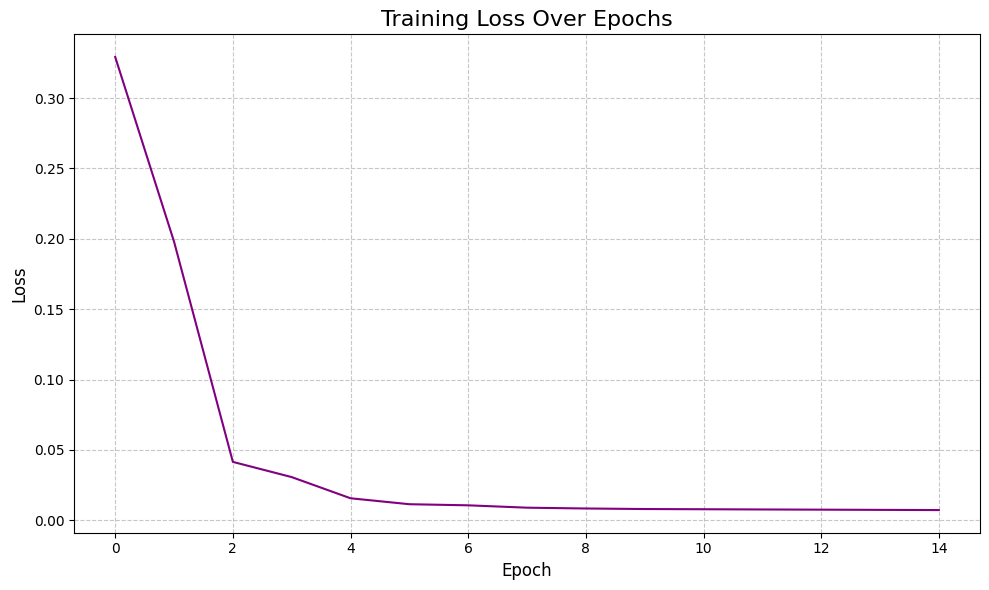

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import plotly.graph_objs as go

# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).requires_grad_()

        lstm_out, _ = self.lstm(x, (h_0.detach(), c_0.detach()))
        predictions = self.linear(lstm_out[:, -1])
        return predictions

# Convert numpy data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size=1, hidden_layer_size=layer_units, output_size=1)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = cur_epochs
batch_size = cur_batch_size
train_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i + batch_size]
        y_batch = y_train_tensor[i:i + batch_size]

        optimizer.zero_grad()
        model_output = model(X_batch)
        loss = loss_function(model_output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= (len(X_train_tensor) / batch_size)
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}')

fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(range(epochs), train_loss, color='purple')

ax.set_title('Training Loss Over Epochs', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

ax.grid(True, linestyle='--', alpha=0.7)

cursor = cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(
    f'Epoch: {int(sel.target[0])}\nLoss: {sel.target[1]:.4f}'))

plt.tight_layout()
plt.show()


In [24]:
# predict stock prices using past window_size stock prices
def preprocess_testdata(data=df, scaler=scaler, window_size=window_size, test=test):
    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = [raw[i-window_size:i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdata()
X_test_tensor = torch.Tensor(X_test)

model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculations as we are making predictions
    predicted_price_ = model(X_test_tensor)

predicted_price_ = predicted_price_.numpy() # Convert to numpy array
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price
test["Predictions_lstm"] = predicted_price

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


RMSE: 15.52
MAPE: 2.94%


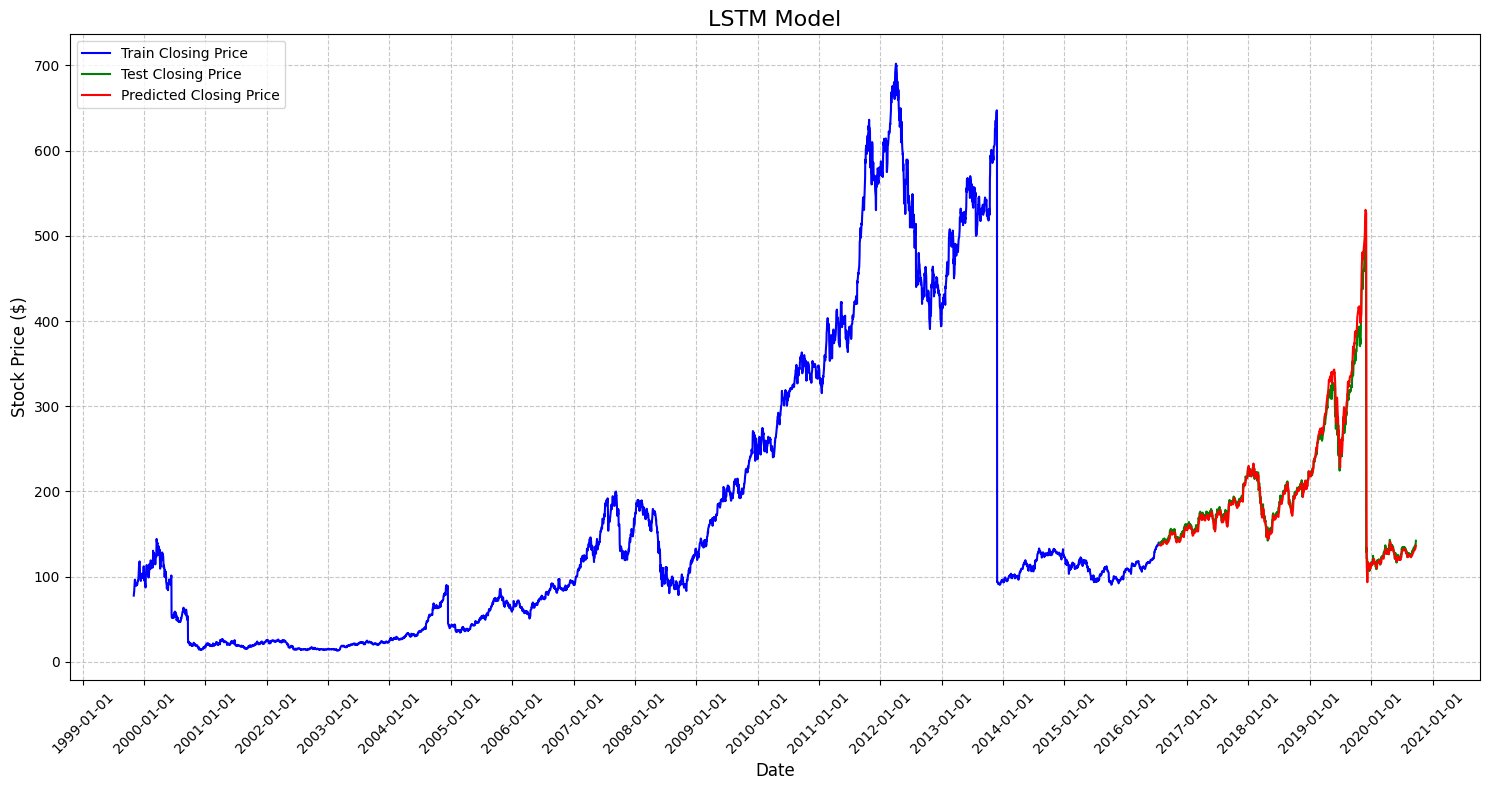

In [33]:
from mplcursors import cursor

# Evaluate performance
rmse_lstm = calculate_rmse(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = calculate_mape(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
# Print performance metrics
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAPE: {mape_lstm:.2f}%")

# Assuming the start date of your dataset
start_date = "1999-11-01"
end_date = "2021-07-09"

# Generate the full date range for the entire dataset
all_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' frequency assumes business days

# Ensure the dates match the length of your train and test data
dates_train = all_dates[:len(train)]
dates_test = all_dates[len(train):len(train) + len(test)]

# Assign these date ranges to your DataFrames
train.index = dates_train
test.index = dates_test

def plot_stock_trend_lstm(train, test):
    fig, ax = plt.subplots(figsize=(15, 8))

    ax.plot(train.index, train["Close"], color='blue', label='Train Closing Price')
    ax.plot(test.index, test["Close"], color='green', label='Test Closing Price')
    ax.plot(test.index, test["Predictions_lstm"], color='red', label='Predicted Closing Price')

    ax.set_title("LSTM Model", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Stock Price ($)", fontsize=12)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(loc='upper left')

    lstm_cursor = cursor(hover=True)
    lstm_cursor.connect("add", lambda sel: sel.annotation.set_text(
        f'Date: {sel.target[0]:%Y-%m-%d}\nPrice: ${sel.target[1]:.2f}'))

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_stock_trend_lstm(train, test)
